# 2次元順圧渦度方程式

## 支配方程式

順圧渦度方程式は、最も簡単な2次元非圧縮流である。例えば Lauritzen et al (2010) の (1.69) 式より、
$$
  \frac{D \zeta}{D t} = 0
$$
もしくはこれを書き下して
$$
  \frac{\partial \zeta}{\partial t} + u \frac{\partial \zeta}{\partial x} + v \frac{\partial \zeta}{\partial y} = 0
$$
もしくはflux型で、
$$
  \frac{\partial \zeta}{\partial t} + \frac{\partial}{\partial x} \left( u \zeta \right) + \frac{\partial}{\partial y} \left( v \zeta \right) = 0
$$
とかける。但し渦度は
$$
  \zeta = \triangle \psi \\
  u = -\frac{\partial \psi}{\partial y} \\
  v = \frac{\partial \psi}{\partial x}
$$
とかける。

通常はスペクトル法で解かれるこの方程式を、有限体積法で解いてみる。。。はじめはreferenceとしてスペクトル法で実装するのがよいか？（Poissonソルバを作らなくてもよさそうだし・・・）
周期境界条件を考え、初期条件は $\zeta = sin(8x/Lx) \sin(8y/Ly)$ とする。

## 準備

In [1]:
using PyPlot
using OffsetArrays  # 配列の添え字を自由にする

## 次元

In [2]:
imax = 100
jmax = imax

100

In [20]:
dx = 1.0 / imax
x = range( 0, (imax-1)*dx, step=dx )
y = range( 0, (jmax-1)*dx, step=dx )

0.0:0.01:0.99

## パラメータ

In [22]:
eps = 1.0e-4
kx = 4  # 初期条件の波数
ky = 4

4

## 境界条件

In [ ]:
#=
function BoundaryCondition!(phi, zeta)
    # 左右の壁
    for j in 1:jmax
        zeta[1,j]    = -2.0 * phi[2,j] / ( dx * dx ) 
        zeta[imax,j] = -2.0 * phi[imax-1,j] / ( dx * dx ) 
    end
    # 上下の壁
    for i in 1:imax
        zeta[i,1]    = -2.0 * phi[i,2] / (dx * dx)
        zeta[i,jmax] = -2.0 * ( phi[i,jmax-1] + dx ) / (dx * dx)
    end
end
=#

## Poissonソルバ
「偏微分方程式の差分解法」p.76を参照。

## 反復法
$$
    \zeta_{i,j} \leftarrow \frac{\zeta_{i+1,j}+\zeta_{i-1,j}+\zeta_{i,j+1}+\zeta_{i,j-1}}{4} + \frac{Re}{16} \left\{ \left( \phi_{i+1,j} - \phi_{i-1,j} \right) \left( \zeta_{i,j+1} - \zeta_{i,j-1} \right) - \left( \phi_{i,j+1} - \phi_{i,j-1} \right) \left( \zeta_{i+1,j} - \zeta_{i-1,j} \right) \right\} \\
    \phi_{i,j} \leftarrow \frac{1}{4} \left( \phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1} \right) + \frac{dx^2}{4} \zeta_{i,j}
$$

In [ ]:
#=
function OneIteration!(phi, zeta)
    # zetaの更新
    zeta_prev = copy(zeta)
    for j in 2:jmax-1
        for i in 2:imax-1
            rhs = ( ( zeta[i+1,j] + zeta[i-1,j] + zeta[i,j+1] + zeta[i,j-1] ) / 4.0
                  + ( ( phi[i+1,j] - phi[i-1,j] ) * ( zeta[i,j+1] - zeta[i,j-1] ) - ( phi[i,j+1] - phi[i,j-1] ) * ( zeta[i+1,j] - zeta[i-1,j] ) ) * Re / 16.0
                  )
            zeta[i,j] = zeta[i,j] * ( 1.0 - const1 ) + rhs * const1
        end
    end

    # zetaの収束判定
    err1 = maximum( abs.( zeta - zeta_prev ) ./ max.(1.0e-8, abs.(zeta_prev) ) )
    
    # phiの更新
    phi_prev = copy(phi)
    for j in 2:jmax-1
        for i in 2:imax-1
            rhs = ( ( phi[i+1,j] + phi[i-1,j] + phi[i,j+1] + phi[i,j-1] ) / 4.0
                  + zeta[i,j] * dx * dx / 4.0
                  )
            phi[i,j] = phi[i,j] * ( 1.0 - const2 ) + rhs * const2
        end
    end
    
    # phiの収束判定
    err2 = maximum( abs.( phi - phi_prev ) ./ max.(1.0e-8, abs.(phi_prev) ) )
    
    return max( err1, err2 )
end
=#

## 初期条件

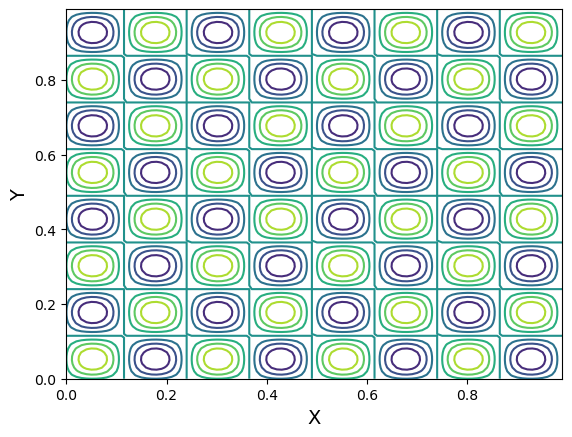

PyObject Text(29.000000000000007, 0.5, 'Y')

In [23]:
zeta = zeros(Float64,imax,jmax)
for j in 1:jmax
    for i in 1:imax
        zeta[i,j] = sin(2 * pi * i * kx / imax) * sin(2 * pi * j * ky / jmax)
    end
end
cont = contour( x, y, zeta' )
xlabel( "X", fontsize=14 )
ylabel( "Y", fontsize=14 )

## 実行

In [ ]:
#=
for n in 1:nmax
    BoundaryCondition!(phi, zeta)
    
    err = OneIteration!(phi, zeta)
    
    if err < eps
        println( "Converge at n=", n )
        break
    end
    if n == nmax
        println( "Do not converge!" )
    end
end
=#

In [ ]:
#=
# plot( x, y, phi )
# contourはv(y,x)という配列を前提にしているため、phiの転置を取る必要がある
cont = contour( x, y, phi' )
xlabel( "X", fontsize=14 )
ylabel( "Y", fontsize=14 )
=#